<a href="https://colab.research.google.com/github/KavindiPathiraja/Deep-Learning-Lab7-part2/blob/main/DLAssignment_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16 Transfer Learning for Pneumonia Detection

## Install and import required libraries

In [1]:
!nvidia-smi

Sat Oct 11 04:06:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow keras numpy pandas matplotlib seaborn scikit-learn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import os
import zipfile
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Extract Dataset

In [4]:
import zipfile
import shutil

zip_path = "/content/drive/MyDrive/DL Assignment/archive.zip"

shutil.copy(zip_path, "/content/")

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset structure:")
!find /content/chest_xray -type d -print


Extracting dataset...
Dataset structure:
/content/chest_xray
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/__MACOSX/chest_xray/val
/content/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/val/NORMAL
/content/chest_xray/__MACOSX/chest_xray/train
/content/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX/chest_xray/test
/content/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/val/PNEUMONIA
/content/chest_xray/chest_xray/val/NORMAL
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/train/PNE

## Explore the Dataset

In [5]:
dataset_path = '/content/chest_xray'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
val_path = os.path.join(dataset_path, 'val')

def explore_dataset():
    print("Dataset Exploration:")
    print("=" * 50)

    for split in ['train', 'test', 'val']:
        split_path = os.path.join(dataset_path, split)
        normal_path = os.path.join(split_path, 'NORMAL')
        pneumonia_path = os.path.join(split_path, 'PNEUMONIA')

        normal_count = len(os.listdir(normal_path))
        pneumonia_count = len(os.listdir(pneumonia_path))
        total_count = normal_count + pneumonia_count

        print(f"\n{split.upper()} SET:")
        print(f"Normal images: {normal_count}")
        print(f"Pneumonia images: {pneumonia_count}")
        print(f"Total images: {total_count}")
        print(f"Pneumonia ratio: {pneumonia_count/total_count:.2%}")

explore_dataset()

Dataset Exploration:

TRAIN SET:
Normal images: 1341
Pneumonia images: 3875
Total images: 5216
Pneumonia ratio: 74.29%

TEST SET:
Normal images: 234
Pneumonia images: 390
Total images: 624
Pneumonia ratio: 62.50%

VAL SET:
Normal images: 8
Pneumonia images: 8
Total images: 16
Pneumonia ratio: 50.00%


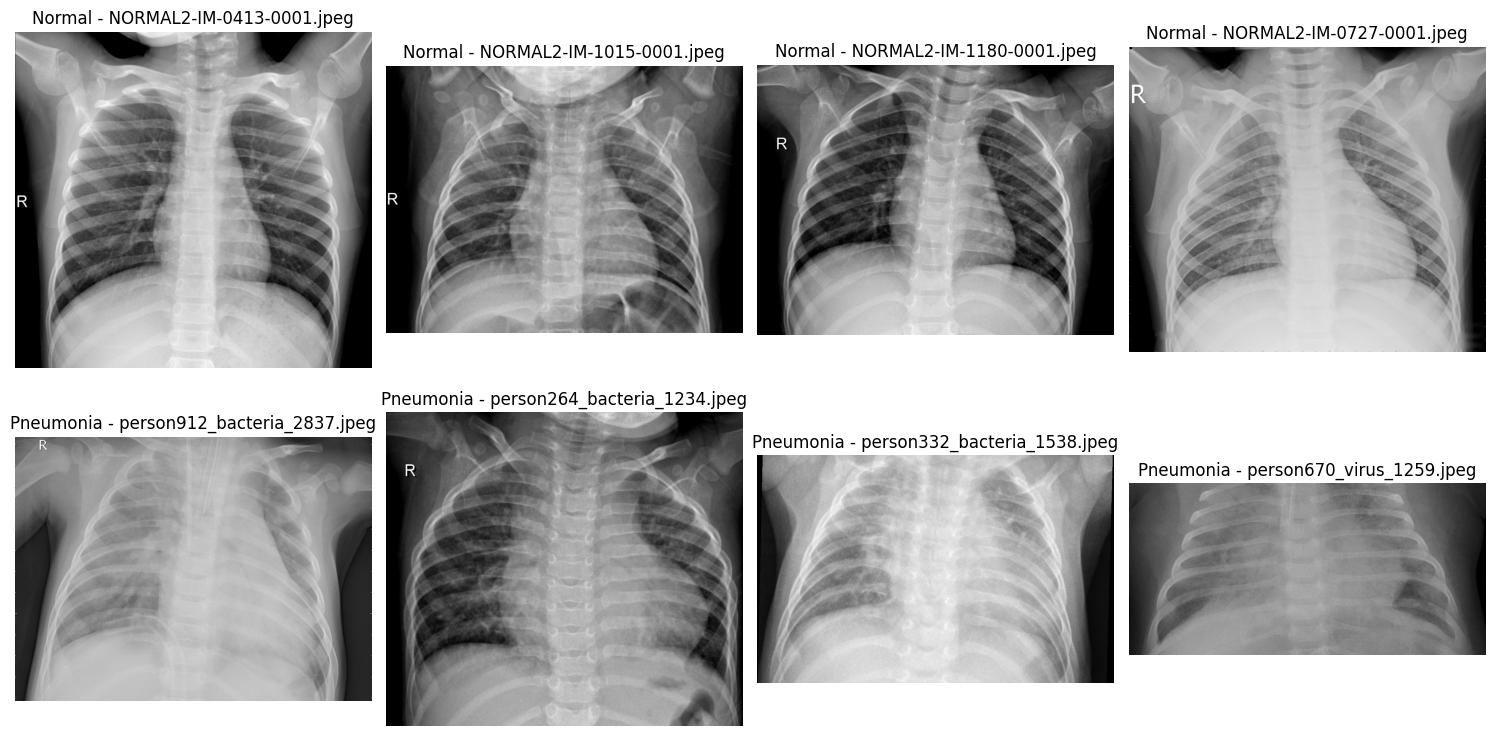

In [6]:
# Visualize the sample images
def visualize_samples():
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Normal samples
    normal_path = os.path.join(train_path, 'NORMAL')
    normal_images = os.listdir(normal_path)[:4]

    for i, img_name in enumerate(normal_images):
        img_path = os.path.join(normal_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Normal - {img_name}')
        axes[0, i].axis('off')

    # Pneumonia samples
    pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
    pneumonia_images = os.listdir(pneumonia_path)[:4]

    for i, img_name in enumerate(pneumonia_images):
        img_path = os.path.join(pneumonia_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'Pneumonia - {img_name}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples()

## Data Preprocessing and Augmentation

In [7]:
IMG_HEIGHT = 224  # VGG16 expects 224x224 images
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Random horizontal shift
    height_shift_range=0.2,   # Random vertical shift
    horizontal_flip=True,     # Random horizontal flip
    zoom_range=0.2,           # Random zoom
    shear_range=0.2,          # Random shear
    fill_mode='nearest'       # Fill missing pixels
)

# Only rescaling for validation and test (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Creating data generators...")

Creating data generators...


In [8]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',      # Binary classification
    color_mode='rgb',         # 3 channels for VGG16
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Display class indices
class_indices = train_generator.class_indices
print(f"Class indices: {class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624


## Build VGG16 Transfer Learning Model

In [9]:
def create_vgg16_model():
    """
    Create VGG16 transfer learning model for pneumonia detection
    """
    # Load pre-trained VGG16 model
    base_model = VGG16(
        weights='imagenet',       # Pre-trained on ImageNet
        include_top=False,        # Exclude the final classification layers
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze the base model layers (they won't be trained)
    base_model.trainable = False

    # Create the complete model
    model = Sequential([
        base_model,              # VGG16 base
        Flatten(),               # Flatten the feature maps
        Dense(256, activation='relu'),  # Fully connected layer
        Dropout(0.5),            # Dropout for regularization
        Dense(128, activation='relu'),  # Another fully connected layer
        Dropout(0.3),            # Another dropout
        Dense(1, activation='sigmoid')  # Output layer (binary classification)
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Low learning rate for transfer learning
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Create the model
print("Building VGG16 model...")
vgg_model = create_vgg16_model()

# Display model summary
print("Model Summary:")
vgg_model.summary()

Building VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,170,497 (80.76 MB)

 Trainable params: 6,455,809 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Define Callbacks

In [10]:
def setup_callbacks():
    """
    Set up callbacks for training
    """
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Reduce learning rate when validation loss plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    # Save the best model
    checkpoint = ModelCheckpoint(
        'best_vgg16_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return [early_stop, reduce_lr, checkpoint]

callbacks = setup_callbacks()
print("Callbacks setup complete!")

Callbacks setup complete!


## Train the Model

In [11]:
print("Starting model training...")
EPOCHS = 30

# Calculate steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
val_steps = validation_generator.samples // BATCH_SIZE

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

# Train the model
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting model training...
Training steps per epoch: 163
Validation steps per epoch: 0
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.8083 - loss: 0.3982 - precision: 0.8347 - recall: 0.9287
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to best_vgg16_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 731ms/step - accuracy: 0.8086 - loss: 0.3977 - precision: 0.8349 - recall: 0.9287 - val_accuracy: 0.8125 - val_loss: 0.4576 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8984 - loss: 0.2394 - precision: 0.9307 - recall: 0.9335
Epoch 2: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 669ms/step - accuracy: 0.8985 - loss: 0.2393 - precision: 0.9308 - recall: 0.9335 - val_accuracy: 0.7500 - val_loss: 0.5602 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9281 - loss: 0.1812 - precision: 0.9575 - recall: 0.9452
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 657ms/step - accuracy: 0.9282 - loss: 0.1812 - precision: 0.9575 - recall: 0.9452 - val_accuracy: 0.7500 - val_loss: 0.2853 - val_precision: 0.7000 - va

## Evaluate the Model

In [12]:
def evaluate_model(model, test_generator):
    """
    Evaluate the model on test data
    """
    print("Evaluating model on test set...")

    # Evaluate metrics
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

    print(f"\nTest Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

    # Make predictions
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # True labels
    true_classes = test_generator.classes

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=['Normal', 'Pneumonia']))

    return test_accuracy, test_precision, test_recall, predictions, predicted_classes

# Evaluate the model
test_accuracy, test_precision, test_recall, predictions, predicted_classes = evaluate_model(vgg_model, test_generator)

Evaluating model on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.8900 - loss: 0.2948 - precision: 0.5329 - recall: 0.6148

Test Results:
Accuracy: 0.9022
Precision: 0.9144
Recall: 0.9308
F1-Score: 0.9225
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.85      0.87       234
   Pneumonia       0.91      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.90       624
weighted avg       0.90      0.90      0.90       624



## Visualize Results

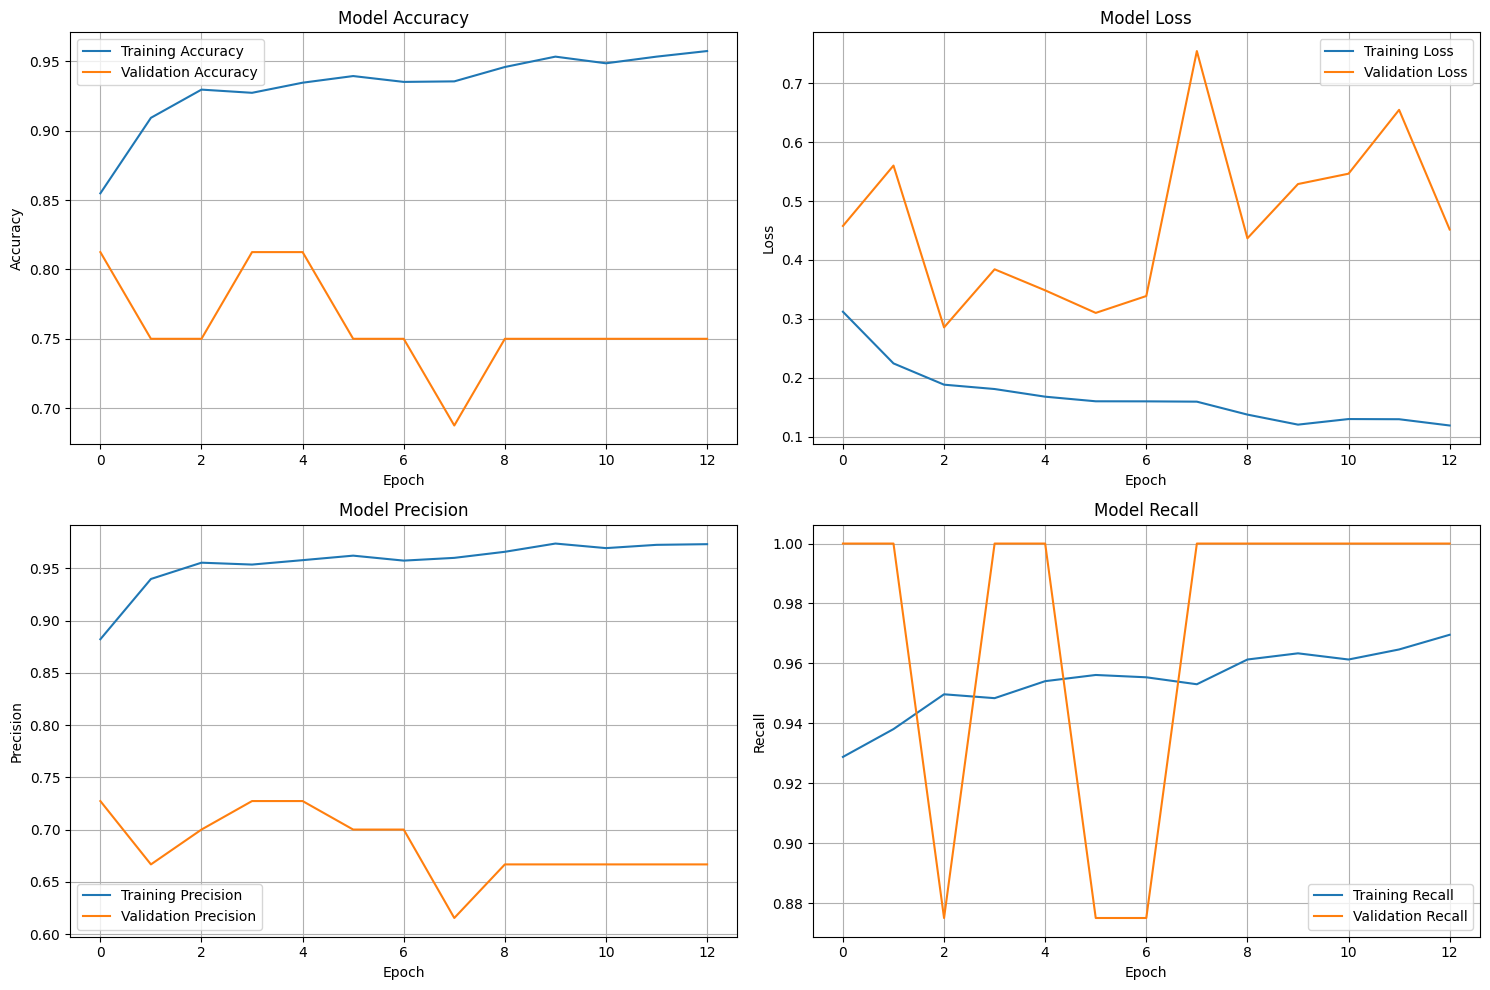

In [13]:
def plot_training_history(history):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

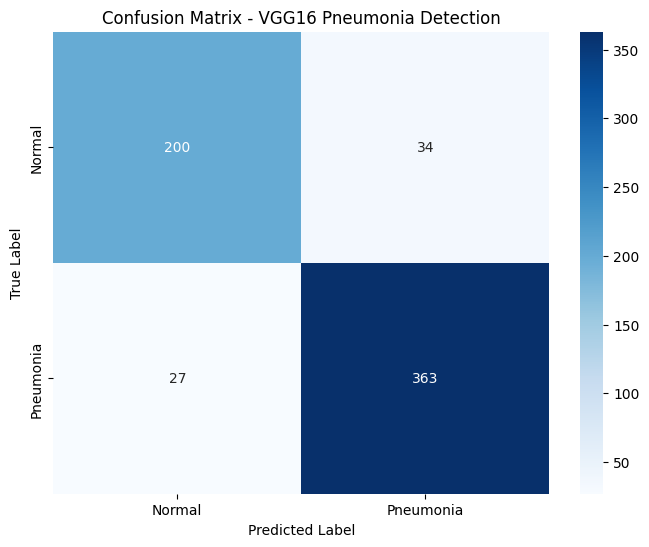

In [14]:
# Plot confusion matrix
def plot_confusion_matrix(test_generator, predicted_classes):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(test_generator.classes, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix - VGG16 Pneumonia Detection')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(test_generator, predicted_classes)

## Sample Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


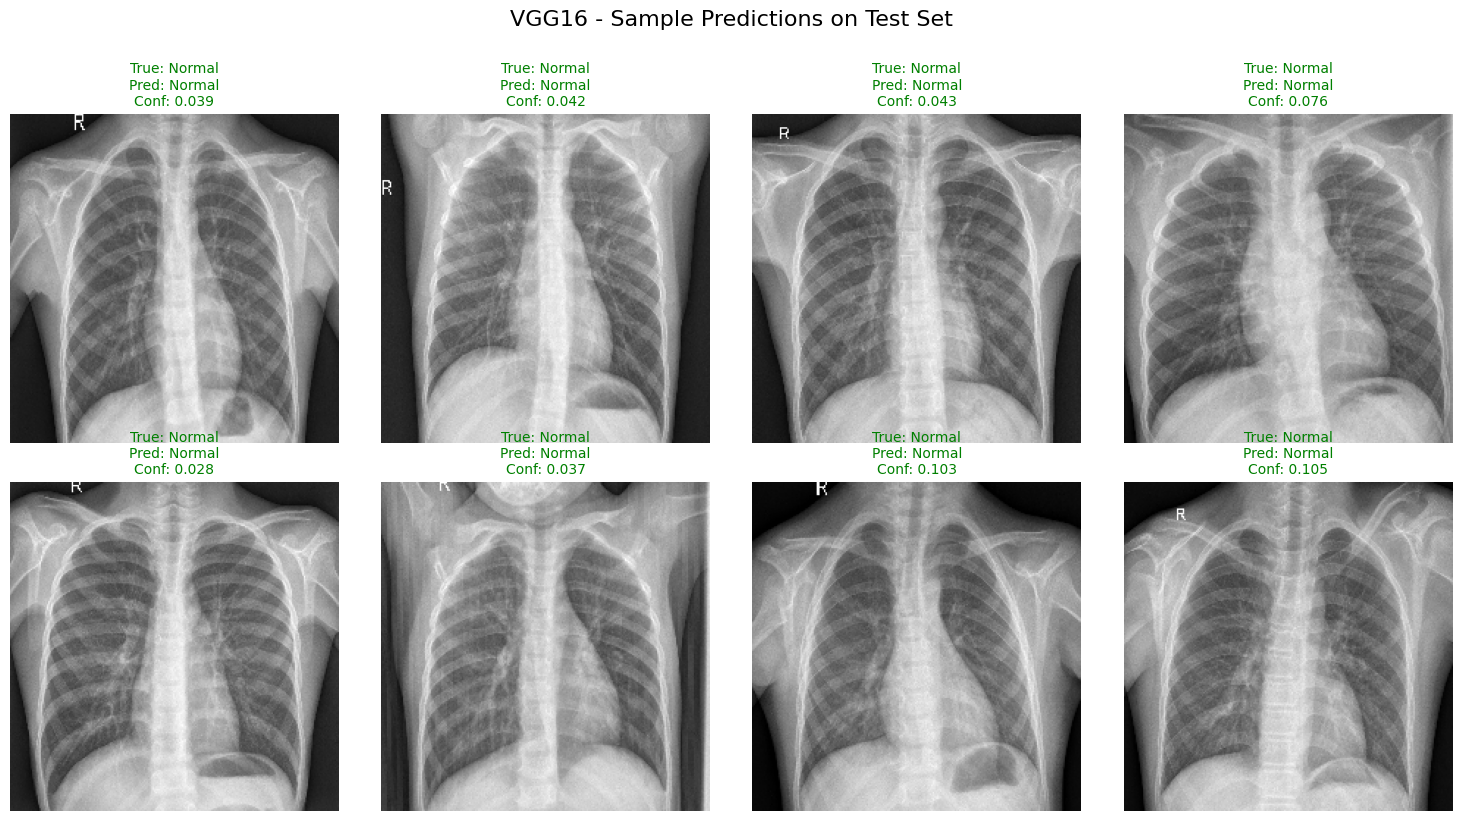

In [15]:
# Step 10: Display sample predictions
def display_sample_predictions(model, test_generator, num_samples=8):
    """
    Display sample predictions with true and predicted labels
    """
    # Get a batch of test data
    test_generator.reset()
    x_batch, y_batch = next(test_generator)

    # Make predictions for this batch
    predictions = model.predict(x_batch[:num_samples])
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    true_labels = y_batch[:num_samples].astype(int)

    # Class names
    class_names = {0: 'Normal', 1: 'Pneumonia'}

    # Plot samples
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')

        true_class = class_names[true_labels[i]]
        pred_class = class_names[predicted_labels[i]]
        confidence = predictions[i][0]

        # Color code: green for correct, red for incorrect
        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'

        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}',
                         color=color, fontsize=10)

    plt.suptitle('VGG16 - Sample Predictions on Test Set', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

display_sample_predictions(vgg_model, test_generator)

## Save the Model

In [16]:
def save_model(model, history):
    """
    Save the trained model and training history
    """
    # Save the model
    model.save('vgg16_pneumonia_detection.h5')
    print("Model saved as 'vgg16_pneumonia_detection.h5'")

    # Save training history to CSV
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('training_history.csv', index=False)
    print("Training history saved as 'training_history.csv'")

    # Save final metrics
    metrics = {
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': 2 * (test_precision * test_recall) / (test_precision + test_recall)
    }

    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv('model_metrics.csv', index=False)
    print("Model metrics saved as 'model_metrics.csv'")

save_model(vgg_model, history)

Model saved as 'vgg16_pneumonia_detection.h5'
Training history saved as 'training_history.csv'
Model metrics saved as 'model_metrics.csv'
